In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=14)

In [2]:
from scipy.integrate import odeint

from jointly_smooth_functions import JointlySmoothFunctions
from datafold.dynfold import LocalRegressionSelection

# install this with "pip install datafold"
import datafold.pcfold as pfold
import datafold.dynfold as dfold

from sklearn.preprocessing import StandardScaler

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

## Subsystem Two

In [3]:
def midlevel_MEK_ERK_model2(x, t, k4, k5, k6):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    dS1  =  -k4*x[0]*x[3] +k5*x[1]
    dES1 =  k4*x[0]*x[3] - k5*x[1] - k6*x[1]
    dS2  =  k6*x[1]
    dE   = -k4*x[0]*x[3]+ k5*x[1]  + k6*x[1]
    
    return [dS1,dES1, dS2, dE]

In [4]:
use_S2_only = False
generator = np.random.RandomState(12345)

num_samples = 2000
num_steps = 20
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 12.5, num_steps + 1)
delta_k = 0.2 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size-1))
observations = np.zeros((num_samples, (1 if use_S2_only else 4)*num_steps)) # data to be used for DMaps
# Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.97, 7000 ,10000])
for i in range(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size -1)
    sol = odeint(midlevel_MEK_ERK_model2, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[1:,2]
    else:
        observations[i,:] = sol[1:,:].reshape(1,-1)
        
k_eff = rate_constants[:,0]*rate_constants[:,2]/(rate_constants[:,2]+rate_constants[:,1])

Observations is the matrix in which the output/behaviors are being saved (its a matrix with the rows being the different data points/experiments and the rows the saved outputs.

The way the code runs right now produces 2000 samples and saves all 4 chemical species by changing the use_S2_only to True you will save only one of the chemical species.

In [5]:
rate_constants_scaled = StandardScaler().fit_transform(rate_constants)
observations_scaled = StandardScaler(with_std=False).fit_transform(observations)

s1 = observations_scaled
s2 = rate_constants_scaled

# now try to compute jointly smooth functions on the two data sets.

We also scramble half of the columns of the observations.

In [6]:
n_kernel_evecs = 250
n_common_evecs = 25

cknn_k_neighbor = 50
cknn_delta = 1

kernel_tolerance = 1e-9
eigenvector_tolerance = 1e-8

rng = np.random.default_rng(1)
s1_scrambled = s1.copy()
s1_remove = s1[:, :s1.shape[1]//2]
s1_scrambled[:, :s1.shape[1]//2] = rng.uniform(low=np.min(s1_remove,axis=0),
                                              high=np.max(s1_remove, axis=0),
                                              size=(s1.shape[0], s1.shape[1]//2))

# print("s1 low", np.min(s1_remove,axis=0))
# print("s1 high", np.max(s1_remove,axis=0))

kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)

jsf = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel=None, kernel_eigenvalue_cut_off=kernel_tolerance, 
                             eigenvector_tolerance=eigenvector_tolerance,optimizer_result_scaling=3, backend='scipy.kdtree')

jsf.fit(np.column_stack([s1_scrambled, s2]), ending_points=[s1.shape[1], s1.shape[1]+s2.shape[1]])

JointlySmoothFunctions(eigenvector_tolerance=1e-08,
                       kernel_eigenvalue_cut_off=1e-09,
                       n_jointly_smooth_functions=25, n_kernel_eigenvectors=250,
                       optimizer_result_scaling=3)

17.06827430455152
42.06827430455152


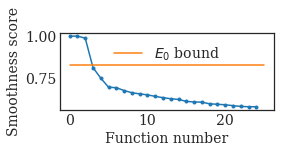

In [7]:

_e0 = jsf.calculate_E0()

fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.plot(jsf.eigenvalues,'.-')
ax.plot([0, len(jsf.eigenvalues)], [_e0, _e0], label=r"$E_0$ bound")
ax.set_xlabel("Function number")
ax.set_ylabel("Smoothness score")
ax.legend()
print(jsf.eigenvalues.sum())
print(jsf.calculate_truncated_energies().sum())

fig.tight_layout()

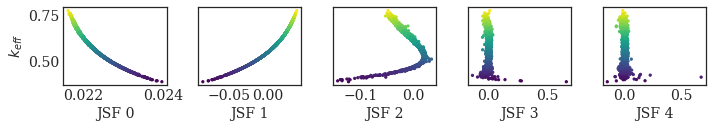

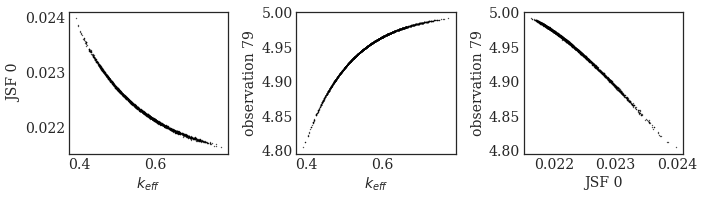

In [8]:
# plot the JSF over the effective parameter

idx_plot = np.arange(observations.shape[0])
map_to_observation = observations[:,-2]

use_smooth_function = jsf.jointly_smooth_functions[idx_plot, 0]

n_plots = 5
m_s = 5
cmap2 = "viridis"
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*2.,2), sharey=True)
for k in range(len(ax)):
    ax[k].scatter(jsf.jointly_smooth_functions[idx_plot,k],k_eff[idx_plot,].ravel(), c=k_eff[idx_plot], s=5, cmap=cmap2)
    # ax[k].set_xlabel(r"jointly smooth function")
    ax[k].set_xlabel(f"JSF {k}")
    if k==0:
        ax[k].set_ylabel(r"$k_{eff}$")

fig.tight_layout()
fig.savefig("jsf_example2_functions.pdf")
fig.savefig("jsf_example2_functions.png")

fig,ax=plt.subplots(1,3,figsize=(10.,3), sharey=False)
ax[2].scatter(use_smooth_function, map_to_observation, c="black", s=.1, cmap=cmap2)
ax[2].set_xlabel(f"JSF 0")
ax[2].set_ylabel(r"observation 79")
ax[1].set_ylabel(r"observation 79")
ax[1].scatter(k_eff, map_to_observation, c="black", s=.1, cmap=cmap2)
ax[1].set_xlabel(r"$k_{eff}$")

#fig.tight_layout()

#fig.savefig("jsf_example2_functionslast.pdf")
#fig.savefig("jsf_example2_functionslast.png")

#fig,ax=plt.subplots(1,1,figsize=(2.5,2), sharey=True)
ax[0].scatter(k_eff, use_smooth_function, c="black", s=.1, cmap=cmap2)
ax[0].set_ylabel(f"JSF 0")
ax[0].set_xlabel(r"$k_{eff}$")

fig.tight_layout()

# fig.savefig("jsf_example2_functionskeff.pdf")
# fig.savefig("jsf_example2_functionskeff.png")



In [9]:
# first span only the common function space
pcm = pfold.PCManifold(jsf.jointly_smooth_functions[:,0:3])
pcm.optimize_parameters()
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=100, delta=1)
# kernel = pcm.kernel
dmap = dfold.DiffusionMaps(n_eigenpairs=10, kernel=kernel,
                          dist_kwargs=dict( cut_off=np.inf))
dmap.fit(pcm)

DiffusionMaps(dist_kwargs={'cut_off': inf},
              kernel=ContinuousNNKernel(k_neighbor=100, delta=1.0))

In [10]:
evecs_common = dmap.eigenvectors_

In [11]:
selection = LocalRegressionSelection(
    intrinsic_dim=3, n_subsample=500, strategy="dim"
).fit(evecs_common)


print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 4 5]


## Compute Uncommon

In [12]:
# now, remove the common functions from the kernel of the right data set
def remove_subspace(full_space, sub_space):
    c = full_space.T @ sub_space
    for k in range(c.shape[0]):
        remove_direction = sub_space @ c[k,:].reshape(-1)
        full_space[:,k] -= remove_direction
    return full_space,c
fullspace = jsf.kernel_eigenvectors_[1][:,:]
subspace = evecs_common

remainingspace,c = remove_subspace(fullspace, subspace)

print(f"fullspace: {fullspace.shape}, subspace: {subspace.shape}, remainingspace {remainingspace.shape}")

fullspace: (2000, 250), subspace: (2000, 10), remainingspace (2000, 250)


Jointly Smooth Function Between The Remaining and The Parameters

In [13]:

kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)
n_common_evecs=50
jsf_uncommon = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel, kernel_tolerance, 
                             1e-9, backend='scipy.kdtree', cut_off=1e-16,)

jsf_uncommon.fit(np.column_stack([remainingspace, rate_constants_scaled]),
                     ending_points=[remainingspace.shape[1], remainingspace.shape[1]+rate_constants_scaled.shape[1]])


JointlySmoothFunctions(eigenvector_tolerance=1e-09,
                       kernel=ContinuousNNKernel(k_neighbor=50, delta=1.0),
                       kernel_eigenvalue_cut_off=1e-09,
                       n_jointly_smooth_functions=50,
                       n_kernel_eigenvectors=250)

49.581979856562896
99.58197985656294


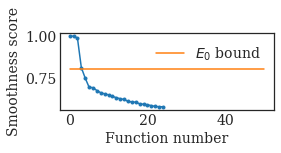

In [14]:
_e0 = jsf_uncommon.calculate_E0()

fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.plot(jsf.eigenvalues,'.-')
ax.plot([0, len(jsf_uncommon.eigenvalues)], [_e0, _e0], label=r"$E_0$ bound")
ax.set_xlabel("Function number")
ax.set_ylabel("Smoothness score")
ax.legend()
print(jsf_uncommon.eigenvalues.sum())
print(jsf_uncommon.calculate_truncated_energies().sum())

fig.tight_layout()
fig.savefig("jsf_example2_score.pdf")
fig.savefig("jsf_example2_score.png")

## Uncommon

In [15]:
# first span only the common function space
pcm = pfold.PCManifold(jsf_uncommon.jointly_smooth_functions[:,:3])
pcm.optimize_parameters()
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=150, delta=1)
dmap_uncommon = dfold.DiffusionMaps(n_eigenpairs=10, kernel=kernel,
                          dist_kwargs=dict( cut_off=np.inf))
dmap_uncommon.fit(pcm)

DiffusionMaps(dist_kwargs={'cut_off': inf},
              kernel=ContinuousNNKernel(k_neighbor=150, delta=1.0))

In [16]:
evecs = dmap_uncommon.eigenvectors_

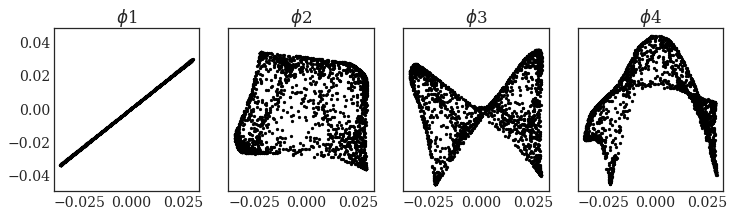

In [17]:
n_plots = 4
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(0,4):
    ax[k].scatter(evecs[:,1], evecs[:,k+1],c='k', s=5)
    ax[k].set_title(r'$\phi$' + str(k+1))
#     ax[k].set_xlim([-0.025,0.025]);ax[k].set_ylim([-0.025,0.025])

In [18]:
selection = LocalRegressionSelection(
    intrinsic_dim=3, n_subsample=100, strategy="dim"
).fit(evecs)

# selection = LocalRegressionSelection(
#     n_subsample=2000, strategy="threshold",regress_threshold=0.35,
# ).fit(evecs)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 2 5]


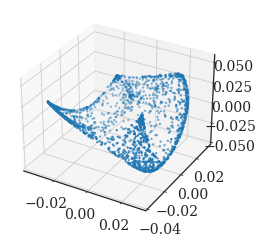

In [19]:
fig  = plt.figure(figsize=(5.5,4))
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(evecs[:,1],evecs[:,2],evecs[:,5],s=2)

### Import Networks Uncommon

In [20]:
auto_encoder_var = np.genfromtxt('auto_enc_var (1).csv',delimiter= ',')[:,0:]

Text(0.5, 0.98, 'The non-meaningful coordinates from the Network colored with the uncommon JSF')

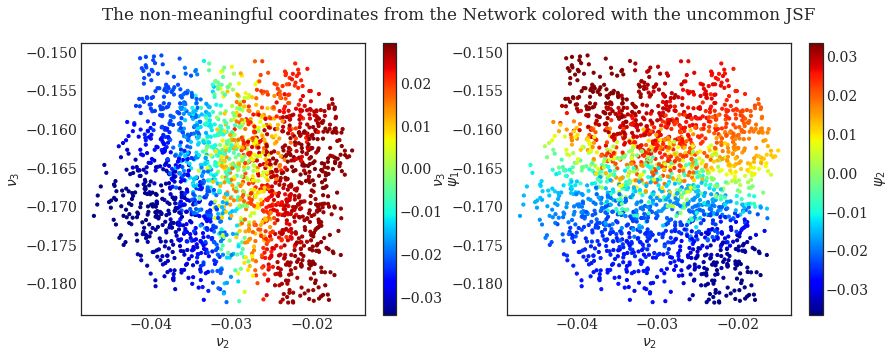

In [21]:
fig = plt.figure(figsize =(14,5))
ax = fig.add_subplot(121)
p =ax.scatter(auto_encoder_var[:,1],auto_encoder_var[:,2],s=10,c=evecs[:,1],cmap='jet')
ax.set_xlabel(r'$\nu_2$');ax.set_ylabel(r'$\nu_3$')
plt.colorbar(p,label =r'$\psi_1$')

ax = fig.add_subplot(122)
p1 =ax.scatter(auto_encoder_var[:,1],auto_encoder_var[:,2],s=10,c=evecs[:,2],cmap='jet')
ax.set_xlabel(r'$\nu_2$');ax.set_ylabel(r'$\nu_3$')
plt.colorbar(p1,label =r'$\psi_2$')

fig.suptitle("The non-meaningful coordinates from the Network colored with the uncommon JSF")

Text(0, 0.5, '$\\psi_2$')

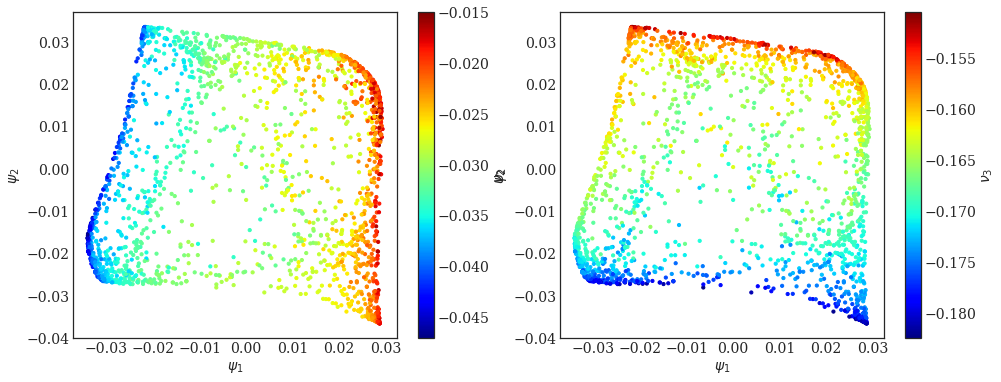

In [22]:
fig = plt.figure(figsize =(16,6))
ax = fig.add_subplot(121)
p = ax.scatter(evecs[:,1],evecs[:,2],s=10,c=auto_encoder_var[:,1],cmap='jet')
plt.colorbar(p,label = r'$\nu_2$')
ax.set_xlabel(r'$\psi_1$');ax.set_ylabel(r'$\psi_2$')

ax = fig.add_subplot(122)
p = ax.scatter(evecs[:,1],evecs[:,2],s=10,c=auto_encoder_var[:,2],cmap='jet')
plt.colorbar(p,label = r'$\nu_3$')
ax.set_xlabel(r'$\psi_1$');ax.set_ylabel(r'$\psi_2$')

# fig.suptitle("Uncommon JSF coordinates colored with the non-meaningful parameters from the Network")